**Project 1**

Dataset: Boston Airbnb dataset

**Motivation:**

For this project, I was interested in exploring the Airbnb dataset from Boston to better understand the following questions:

1.   What we can say about customer’s feelings in the reviews posted after staying in an Airbnb Boston house/apartment?
2.   What is the sentiment analysis of customer review grouped by neighborhood?
3.   Which topics were most commented in the customer review? Listed the words for each *topic*

**Blog Link:**

https://medium.com/@mayrazrodriguez/sentiment-analysis-and-topic-modeling-using-airbnb-dataset-c65848b98a57?source=friends_link&sk=3f85f6c3093b8a3981fd2197da189d37





we import the packages that we will use throughout the project.

In [56]:
import pandas as pd
import io
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import spacy
nlp = spacy.load('en_core_web_sm')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Load the dataset from google colab

In [57]:
from google.colab import files
uploaded = files.upload()

Saving listings.csv to listings (1).csv
Saving reviews.csv to reviews (1).csv


In [58]:
reviews = pd.read_csv(io.BytesIO(uploaded['reviews.csv']))
print("Number of rows in data =",reviews.shape[0])
print("Number of columns in data =",reviews.shape[1])

Number of rows in data = 218718
Number of columns in data = 6


In [59]:
listings = pd.read_csv(io.BytesIO(uploaded['listings.csv']))
print("Number of rows in data =",listings.shape[0])
print("Number of columns in data =",listings.shape[1])

Number of rows in data = 5711
Number of columns in data = 106


The class CleanUp contain the merge_csv method that will be used to extract the neighborhood attribute and join to listings dataset.
The clean_dataset and patterns method was used to remove punctuations, NA values.
The remove_stop_words method was used to remove stop words and additional words.

In [0]:
class CleanUp():
  def __init__(self):
    self.review = pd.read_csv(io.BytesIO(uploaded['reviews.csv']))
    self.listings = pd.read_csv(io.BytesIO(uploaded['listings.csv']))
    self.stopwords  = stopwords.words('english')
       

  def build(self):
    '''
    The code below call to clean_dataset and remove_stopwords methods
    Input paramaters:
        None
    Output paramters:
        a clean dataframe and clean data frame without stop words.
  
    '''
    data = self.merge_csv()
    clean_data = self.clean_dataset(data)
    data_without_stop_word = self.remove_stopwords(clean_data)
    print('Finished cleaning process')
    return clean_data, data_without_stop_word

  def merge_csv(self):
    '''
    The code below merge listings and reviews dataframe.
    Input paramaters:
        None
    Output paramters:
        a merged dataframe
  
    '''
    listings_data = self.listings
    tmp_listings_data = listings_data.loc[:, ['id', 'neighbourhood']]
    reviews_data = self.review
    merged_dataframe = pd.merge(left=reviews_data,right=tmp_listings_data, \
                                    how='left', left_on='listing_id', right_on='id')
    return merged_dataframe

  def patterns(self, text):
    '''
    The code below remove HTML tags, punctuations, numbers.
    Input paramaters:
        text: row of dataframe
    Output paramters:
        a clean text
  
    '''
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('<.*?>', '', text)   
    text = re.sub(r'[^\w\s]', ' ', text) 
    text = re.sub(r'\d+',' ',text) 
    text = re.sub(r'@[\w_-]+', ' ', text)
    return text

  def clean_dataset(self, data):
    '''
    The code below clean dataframe removing NA values, invalid characters
    and white spaces.
    Input paramaters:
        data: dataframe
    Output paramters:
        a clean dataframe
  
    '''
    data = data.drop_duplicates()
    data.columns = map(str.lower, data.columns)
    data = data.apply(lambda x: x.astype(str).str.lower())
    data.drop(columns=['id_y'], inplace=True)
    data.dropna(subset=['comments'], axis=0, inplace=True)
    data['comments'] = data['comments'].map(lambda text : self.patterns(text))
    data['comments'] = data['comments'].replace('\s+', ' ', regex=True)
    data['comments'] = data['comments'].map(lambda text : self.lemmatize_with_postag(text))
    return data

  def lemmatize_with_postag(self,text):
    sent = TextBlob(text)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)
    
  def remove_stopwords(self, clean_data):
    '''
    The code below remove stop words
    and white spaces.
    Input paramaters:
        clean_data: dataframe without invalid characters
    Output paramters:
        a clean dataframe without stop words
  
    '''
    df = clean_data.copy()
    additional_stopwords = ['would','could', 'will', 'kelly','frank',
                            'kevin', 'can', 'may', 'might', 'must',
                            'and', 'i', 'a', 'and', 'so', 'arnt', 'this', 
                            'when', 'did',  'there', 'street',
                            'all', 'front', 'there', 'traci', 'jon', 'jasmine', 
                            'kerry', 'jarrett', 'séjour',
                            'abiel', 'moreover','zoe','every', 'bart', 'charles']
    self.stopwords.extend(additional_stopwords)
    df['comments_clean_text'] = \
            df['comments'].astype(str).str.split().map(
                lambda sl: " ".join(s for s in sl if len(s) > 4))
    df['comments_clean_text'] = df['comments_clean_text'].replace('\s+', ' ', regex=True)
    df.dropna(subset=['comments_clean_text'], axis=0, inplace=True)
    df.loc[:, 'comments_clean_text'] = df['comments_clean_text'].apply(
            lambda x: ' '.join([word for word in word_tokenize(x.lower()) if 
                                word not in self.stopwords]))
    df['comments_clean_text'] = df['comments_clean_text'].str.strip()
    return df

In [65]:
# instance of CleanUp class
preprocess_obj = CleanUp()
df_with_stop_word, df_without_stop_word = preprocess_obj.build()

Finished cleaning process


The steam_word method in AnalysisData class aims to perform the steam process and the score_sentimental method calculates the polarity score of each word.

In [0]:
class AnalysisData():
  def __init__(self):
    pass
  def score_sentimental(self, df_with_stop_word):
    '''
    The code below put a polarity score for each word
    Input paramaters:
        df_with_stop_word: dataframe without invalid characters and stop words
    Output paramters:
        a polarity score array, neighboudhood dataframe and dataframe that contain stop words.
  
    '''
    polarity_score_list = [round(TextBlob(word).polarity,1) for word in df_with_stop_word['comments']]
    df_with_stop_word['polarity_score'] = polarity_score_list
    df_with_stop_word['label_polarity'] = 'neutral'
    df_with_stop_word.loc[df_with_stop_word[df_with_stop_word['polarity_score'] == 0].index, ['label_polarity']] = 'neutral'
    df_with_stop_word.loc[df_with_stop_word[(df_with_stop_word['polarity_score'] > 0) & (df_with_stop_word['polarity_score'] < 0.6)].index,
                 ['label_polarity']] = 'positive'
    df_with_stop_word.loc[df_with_stop_word[(df_with_stop_word['polarity_score'] >= 0.6) & (df_with_stop_word['polarity_score'] <= 1.0)].index,
                 ['label_polarity']] = 'highly positive'
    df_with_stop_word.loc[df_with_stop_word[(df_with_stop_word['polarity_score'] < 0) & (df_with_stop_word['polarity_score'] > -0.6)].index,
                 ['label_polarity']] = 'negative'
    array_polarity_score = np.unique(polarity_score_list, return_counts=True)
    neighborhood_df = df_with_stop_word[['polarity_score', 'neighbourhood']].groupby(['neighbourhood']).agg(['mean', 'count'])
    neighborhood_df.columns = neighborhood_df.columns.droplevel(0)
    print('Finished the polarity analysis')
    return array_polarity_score, neighborhood_df, df_with_stop_word
  

In [67]:
analysis_obj = AnalysisData()
array_polarity_out, neigh_df, output_data_out = analysis_obj.score_sentimental(df_with_stop_word)

Finished the polarity analysis


In [0]:
class PlotModel():
  def __init__(self):
    pass

  def review_polarity_level(self, data):
    '''
    The code below show the polarity distribution. 
    Input paramaters:
        data: dataframe without invalid characters
    Output paramters:
        a plot.
  
    '''
    plt.figure(figsize=(8, 4))
    ax = data['label_polarity'].value_counts().plot(kind='bar',color="indianred")
    ax.set_xlabel("polarity level", fontsize=12)
    ax.set_ylabel("count", fontsize=12)
    plt.show()

  def review_polarity(self, array_polarity_score):
    '''
    The code below show the number of reviews. 
    Input paramaters:
        array_polarity_score: array polarityscore
    Output paramters:
        a plot.
  
    '''
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(array_polarity_score[0], array_polarity_score[1], color="salmon", saturation=.5)
    ax.set_xlabel('Airbnb review', fontsize=14)
    ax.set_ylabel('Number of reviews', fontsize=14)
    plt.savefig('polarity_level_plot', transparent=True,
                    bbox_inches='tight', pad_inches=0)
    plt.show()


  def review_neighborhood(self, neighborhood_df):
    print(neighborhood_df)
    ax = neighborhood_df[['mean']].plot.bar(figsize=(10, 6), legend=False, fontsize=10)
    ax.set_xlabel("Neighbourhood", fontsize=10)
    ax.set_ylabel("Average polarity score", fontsize=10)
    plt.show()
    ax = neighborhood_df[['count']].plot.bar(figsize=(10, 6), legend=False, fontsize=10)
    ax.set_xlabel("Neighbourhood", fontsize=12)
    ax.set_ylabel("Number of review", fontsize=12)
    ax.tick_params(axis="x", labelsize=12)
    plt.show()

  def show_topic_classification(self, feature_names, model,ntopics):
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for j in range(0, ntopics):
      topic = model.components_[j]
      topic_words = [feature_names[i] for i in topic.argsort()[:-25 - 1:-1]]
      topic_cloud = WordCloud(
                background_color='black',
                width=2000,
                height=1800
      ).generate(" ".join(topic_words))
      ax = fig.add_subplot(2,2, j+1)
      ax.imshow(topic_cloud)
      ax.axis('off')
    plt.show()

  def show_topics(self, lda):
      plt.figure(figsize=(12, 8))
      num_col = 3
      num_row = 5
      for i in range(15):
        df = pd.DataFrame(lda.show_topic(i), columns=['term', 'prob']).set_index('term')
        plt.subplot(num_row, num_col, i + 1)
        ax = sns.barplot(x='prob', y=df.index, data=df, palette='Blues')
        ax.set_title('topic ' + str(i), fontdict={'fontsize': 8, 'fontweight': 'medium'})
        ax.set_xlabel('probability', fontsize=8)
        ax.set_ylabel('term', fontsize=8)
        ax.tick_params(axis="y", labelsize=8)
        ax.tick_params(axis="x", labelsize=8)
      plt.show()

Was created an instance of the PlotModel class where we can access the class methods review_polarity, review_neighborhood and show_topic_classification.

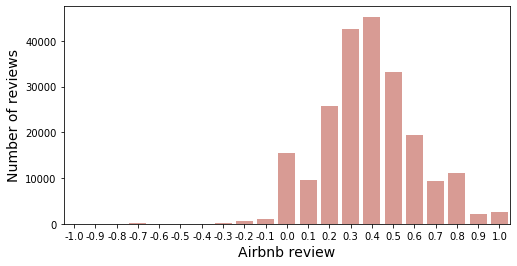

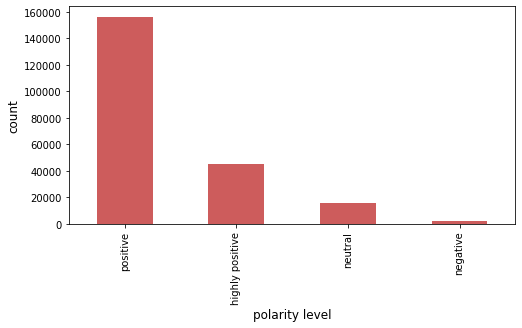

In [70]:
handle_plot = PlotModel()
handle_plot.review_polarity(array_polarity_out)
handle_plot.review_polarity_level(output_data_out)

                        mean  count
neighbourhood                      
allston-brighton    0.389639  17981
back bay            0.399060  13937
beacon hill         0.399982  11365
brookline           0.400000      1
cambridge           0.575000      4
charlestown         0.400576   5039
chestnut hill       0.583333      6
chinatown           0.356662   2169
dorchester          0.370971  26480
downtown            0.381054   8788
downtown crossing   0.381582    885
east boston         0.373198  22439
fenway/kenmore      0.404308   8797
financial district  0.418301    459
government center   0.415183    382
hyde park           0.384490   1657
jamaica plain       0.378874  19327
leather district    0.403468    173
mattapan            0.388486   2180
mission hill        0.357268   3433
north end           0.402840  16867
revere              0.326316     19
roslindale          0.381439   4240
roxbury             0.375380  14277
somerville          0.352941     17
south boston        0.402806

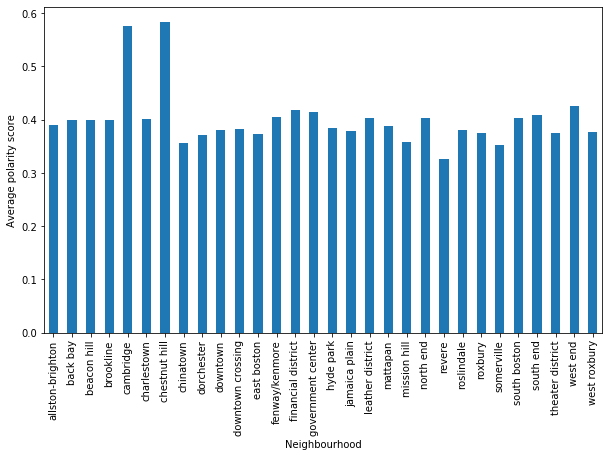

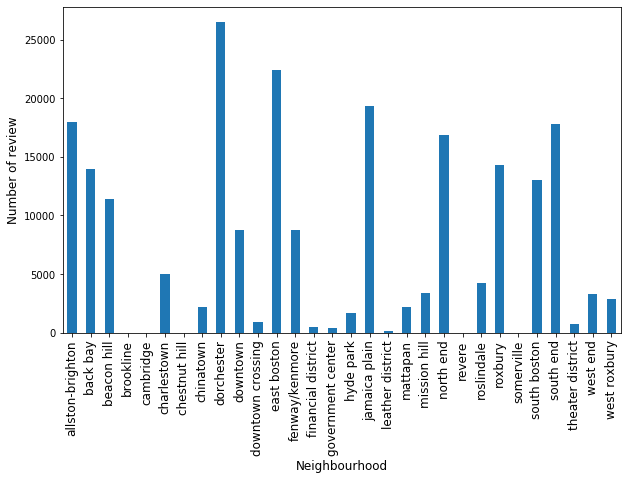

In [71]:
handle_plot.review_neighborhood(neigh_df)

The GetTopic class infers the topic of a text

In [0]:
class GetTopic():
    def __init__(self, df_without_stop_word):
        self.n_topics = 2
        self.num_words_topic = 25
        self.df = df_without_stop_word
        #print(self.df['comments'])
        #self.df.dropna(subset=['comments'], axis=0, inplace=True)
        self.num_rows = self.df.size

    def execute_lda_model(self):
        from sklearn.decomposition import LatentDirichletAllocation
        from sklearn.feature_extraction.text import CountVectorizer
        #self.df['comments']=[" ".join(review) for review in self.df['comments'].values]
        # the vectorizer object will be used to transform text to vector form
        vectorizer = CountVectorizer(token_pattern='\w+|\$[\d\.]+|\S+')
        # apply transformation
        tf = vectorizer.fit_transform(self.df['comments_clean_text'].apply(lambda x: np.str_(x)))
        #tf_feature_names tells us what word each column in the matric represents
        tf_feature_names = vectorizer.get_feature_names()
        number_of_topics = self.n_topics
        model = LatentDirichletAllocation(batch_size=128,
                        n_components=number_of_topics, learning_method='online',
                       random_state=0).fit(tf)
        print('Finished the extract topic step')
        return tf_feature_names, model, self.n_topics
        #self.display_topics(model, tf_feature_names)

    def display_topics(self, model, feature_names):
        no_top_words = self.num_words_topic
        ntopics = self.n_topics
        topic_dict = {}
        for topic_idx, topic in enumerate(model.components_):
            topic_dict["Topic %d words" % (topic_idx)] = ['{}'.format(feature_names[i])
                                                          for i in topic.argsort()[:-no_top_words - 1:-1]]
            topic_dict["Topic %d weights" % (topic_idx)] = ['{:.1f}'.format(topic[i])
                                                            for i in topic.argsort()[:-no_top_words - 1:-1]]
     

The PlotModel class contains all methods that plot results

In [80]:
topic_obj = GetTopic(df_without_stop_word)
feature_names, model, ntopic = topic_obj.execute_lda_model()

Finished the extract topic step


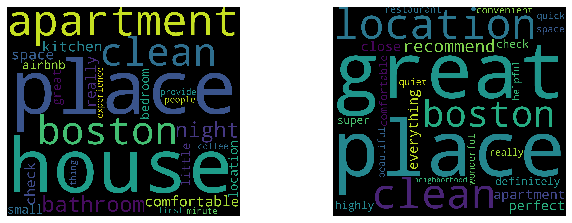

In [81]:
handle_plot.show_topic_classification(feature_names, model,ntopic)